# Epoching Continuous Data, Time Frequency, Evoked Responses & Inversed Modeling

In [1]:
import sys
import os
import os.path as op
import numpy as np
import pandas as pd
sys.path.append("../")
from mne_path import PathHandler
ph = PathHandler()
from glob import glob
import random
import mne

%matplotlib inline

# Loading data

* MNE-Python package was created to work with Neuromag's FIF file format and data structures are based around the FIF file format from Neuromag, 

* Nevertheless, the package consists of reader functions for other data formats and to interface with many publicly available datasets

The downloaded `MNE-sample-data` contains EEG and MEG data from one subject performing an audiovisual experiment, along with structural MRI scans for that subject. 

This sample dataset selected for this analysis is `sample_audvis_filt-0-40_raw.fif` which has previously been filtered and downsampled.  The original raw data is `sample_audvis_raw.fif`.

In [2]:
SAMPLE_DATA_DIR = ph.cddir(ph.SAMPLE_DIR)

# list of all fif files in sample data
FIF_FILES = sorted(glob(op.join(SAMPLE_DATA_DIR, "**/**/*.fif")))

print("Total FIF Files: ", len(FIF_FILES))
display(FIF_FILES[:5])

Changed to:  /Users/jonghang/mne_data/MNE-sample-data
Total FIF Files:  36


['/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/all-trans.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise-cov.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise_raw-eve.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif']

In [3]:
# sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = FIF_FILES[26]
fif_raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file /Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [17]:
print(sample_data_raw_file)

/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif


__Projection Items__

The Projection Items above are SSP projectors calculated to remove environmental noise from the MEG signals, plus a projector to mean-reference the EEG channels.  Details of these projections will be discussed in the future. 

In addition to the information displayed during loading, you can get a glimpse of the basic details of a Raw object by printing it; even more is available by printing its info attribute (a dictionary-like object that is preserved across Raw, Epochs, and Evoked objects). 

The info data structure keeps track of channel locations, applied filters, projectors, etc. Notice especially the chs entry, showing that MNE-Python detects different sensor types and handles each appropriately

# Clean Data using ICA

In [4]:
ICA_METHOD_FAST_ICA = "fastica"
ICA_METHOD_PICARD = "picard"
ICA_METHOD_INFOMAX = "infomax"
ICA_METHOD_INFOMAX_EXT = "extended-infomax"

def get_ica(input_n_components, 
            ica_method = ICA_METHOD_FAST_ICA): 
    """
    Fit FIF raw data into ICA using fast ICA if 
    method is not specified
    """
    fifica = mne.preprocessing.ICA(n_components = input_n_components, 
                                    method = ica_method,
                                    random_state = 13, 
                                    max_iter = 800)
    return fifica

In [5]:
def clean_fif_raw_ica(input_fif_raw, input_n_components = 25,
                      ica_method = ICA_METHOD_FAST_ICA):    
    fif_ica = get_ica(input_n_components = input_n_components,
                      ica_method = ica_method)

    input_fif_raw.load_data()
    # Fit FIF Raw with ICA
    fif_ica.fit(input_fif_raw.copy())

    # Exclude the first component
    fif_ica.exclude = [1]

    raw_cleaned = fif_ica.apply(input_fif_raw.copy())
    return raw_cleaned

# Detect Events

In [6]:
# get the cleaned FIF raw
fif_raw_cleaned = clean_fif_raw_ica(fif_raw, input_n_components=25,
                                   ica_method=ICA_METHOD_FAST_ICA)

events = mne.find_events(fif_raw_cleaned, stim_channel='STI 014')

# show the first 5 events
print(events[:5])  # show the first 5

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 3.4s.
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 364 PCA components
319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [7]:
event_dict = {'auditory/left': 1, 
              'auditory/right': 2, 
              'visual/left': 3,
              'visual/right': 4, 
              'smiley': 5, 
              'buttonpress': 32}

# Epoching continuous data

Epochs objects are a way of representing continuous data as a collection of time-locked trials, stored in an array of shape(n_events, n_channels, n_times). They are useful for many statistical methods in neuroscience, and make it easy to quickly overview what occurs during a trial (https://mne.tools/0.11/auto_tutorials/plot_epochs_objects.html). 

Raw object and the events array are the minimum prerequisites to create an Epochs object, using the MNE Epochs class constructor.  In addition, rejection criteria is specified using a dictionary so that any epoch where peak-to-peak signal amplitude is beyond reasonable limits for that channel type are rejected.  Bare in mind too that values for rejection criteria vary across hardware.

### Specify Rejection Criteria

In [8]:
reject_criteria = dict(mag = 4000e-15,     # 4000 fT
                       grad = 4000e-13,    # 4000 fT/cm
                       eeg = 150e-6,       # 150 µV
                       eog = 250e-6)       # 250 µV

In the Epochs function, specify tmin and tmax.  These parameters are times relative to each event at which to start and end each epoch.

### Create Epochs

In [9]:
epochs = mne.Epochs(fif_raw_cleaned, events, 
                    event_id = event_dict, 
                    tmin = -0.2, tmax = 0.5,
                    reject = reject_criteria, 
                    preload = True)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


## Selection of Conditions for Investigations

In [10]:
selected_conds = ['auditory/left', 
                  'auditory/right',
                  'visual/left', 
                  'visual/right']

epochs.equalize_event_counts(selected_conds)

Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


(<Epochs |  302 events (all good), -0.199795 - 0.499488 sec, baseline -0.199795 – 0 sec, ~95.0 MB, data loaded,
  'auditory/left': 68
  'auditory/right': 68
  'visual/left': 68
  'visual/right': 68
  'smiley': 14
  'buttonpress': 16>,
 array([273, 275, 121, 195, 258, 271, 274]))

## Isolation of Events

In [11]:
epochs_audio = epochs['auditory']
epochs_visual = epochs['visual']
epochs_left = epochs["left"]
epochs_right = epochs["right"]

__Free Up Memory__

In [12]:
# del raw, epochs  # free up memory

Like Raw objects, Epochs objects also have a number of built-in plotting methods. One is plot_image, which shows each epoch as one row of an image map, with color representing signal magnitude; the average evoked response and the sensor location are shown below the image:

### Plot Images for Audio Stimuli `MEG 1332`, `EEG 021`

Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


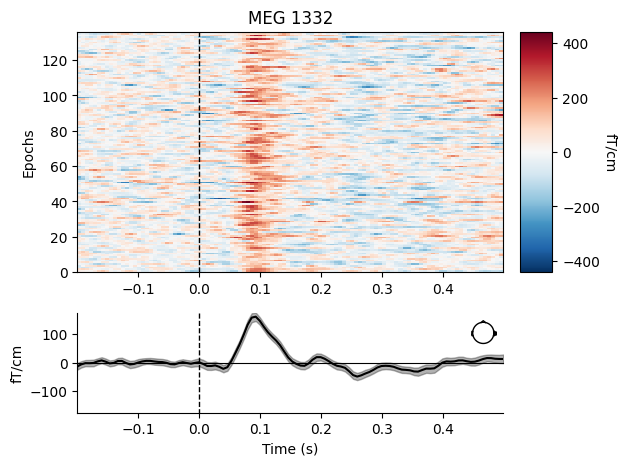

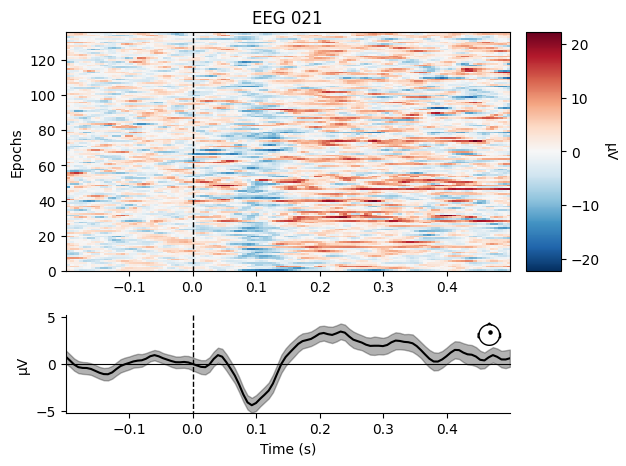

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [13]:
epochs_audio.plot_image(picks=['MEG 1332', 'EEG 021'])

### Plot Images for Visual Stimuli `MEG 1332`, `EEG 021`

Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


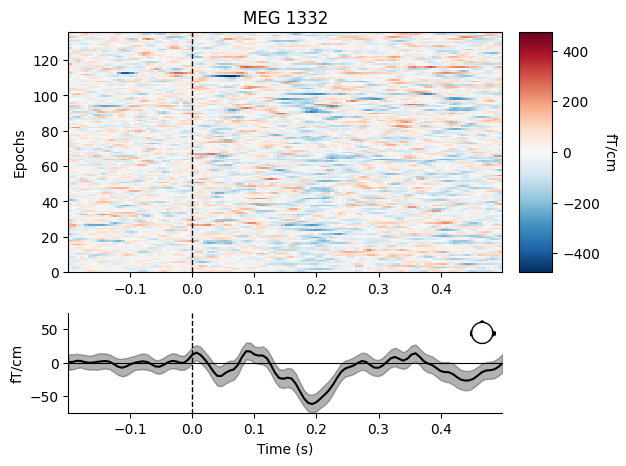

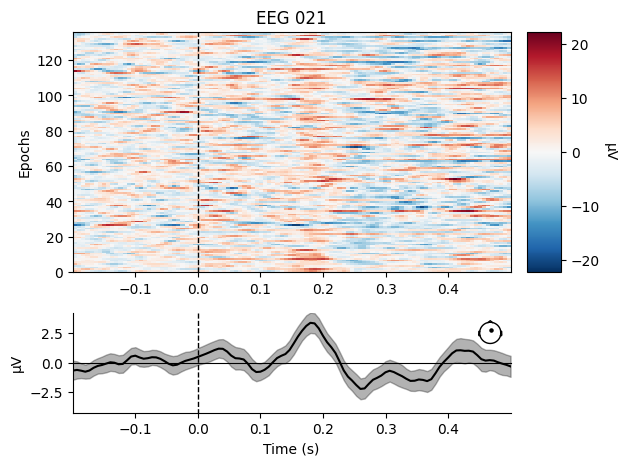

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [14]:
epochs_visual.plot_image(picks=['MEG 1332', 'EEG 021'])

### Plot Images for Left Hemisphere of `MEG 1332`, `EEG 021`

Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


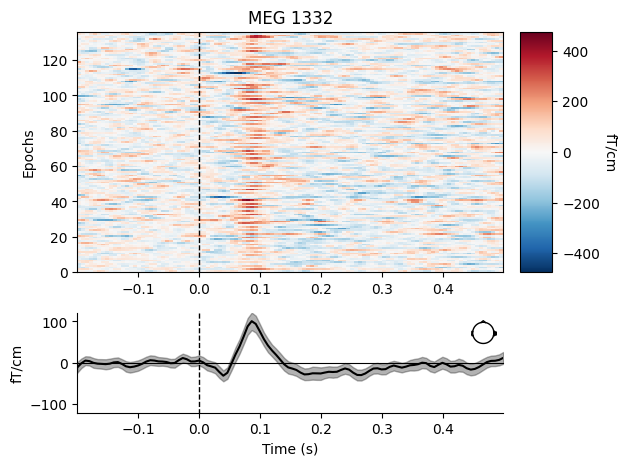

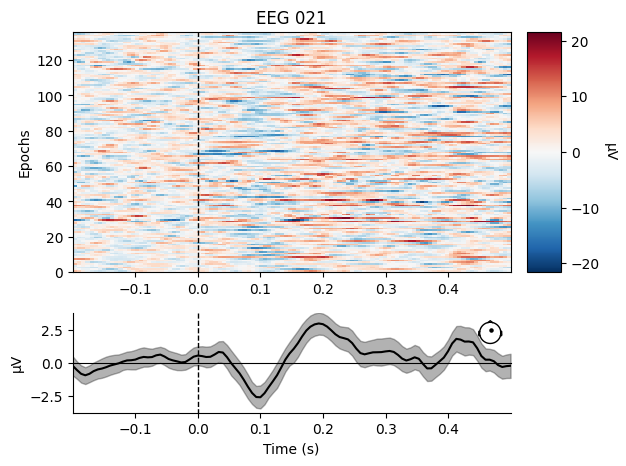

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [15]:
epochs_left.plot_image(picks=['MEG 1332', 'EEG 021'])

### Plot Images for Right Hemisphere of `MEG 1332`, `EEG 021`

Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


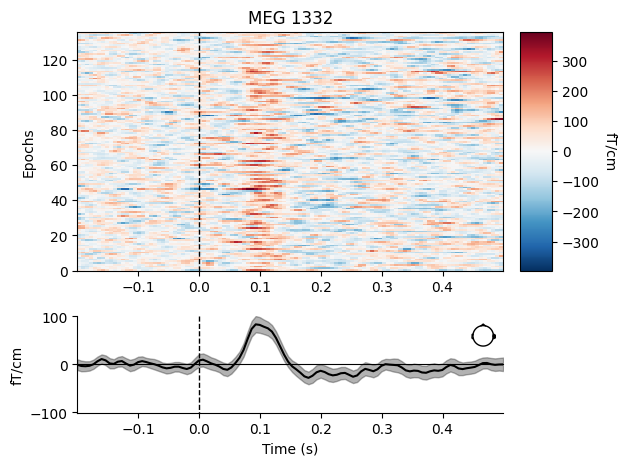

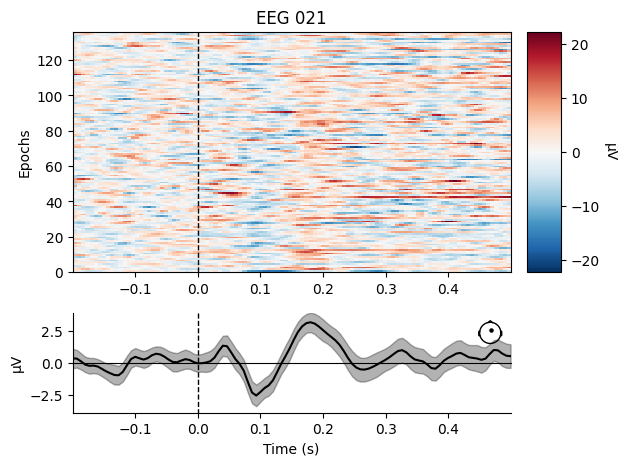

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [16]:
epochs_right.plot_image(picks=['MEG 1332', 'EEG 021'])

Note

Both Raw and Epochs objects have get_data methods that return the underlying data as a NumPy array. Both methods have a picks parameter for subselecting which channel(s) to return; raw.get_data() has additional parameters for restricting the time domain. The resulting matrices have dimension (n_channels, n_times) for Raw and (n_epochs, n_channels, n_times) for Epochs.

# Time-frequency analysis

The mne.time_frequency submodule provides implementations of several algorithms to compute time-frequency representations, power spectral density, and cross-spectral density. Here, for example, we’ll compute for the auditory epochs the induced power at different frequencies and times, using Morlet wavelets. On this dataset the result is not especially informative (it just shows the evoked “auditory N100” response); see here for a more extended example on a dataset with richer frequency content.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
No baseline correction applied


[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:    4.7s finished


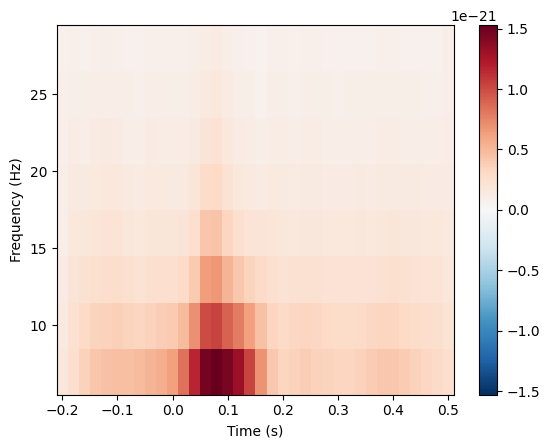

[<Figure size 640x480 with 2 Axes>]

In [11]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=2, return_itc=False,
                                      freqs=frequencies, decim=3)
power.plot(['MEG 1332'])

# Estimating evoked responses

Now that we have our conditions in aud_epochs and vis_epochs, we can get an estimate of evoked responses to auditory versus visual stimuli by averaging together the epochs in each condition. This is as simple as calling the average method on the Epochs object, and then using a function from the mne.viz module to compare the global field power for each sensor type of the two Evoked objects:

https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html

## Compare Evoked Response of `MEG 1332`

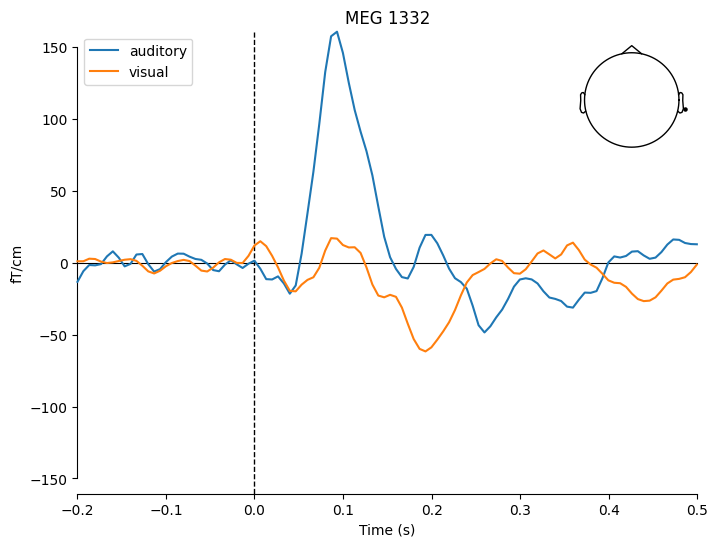

[<Figure size 800x600 with 2 Axes>]

In [18]:
evoked_audio = epochs_audio.average()
evoked_visual = epochs_visual.average()

# Dictionary to store evokeds to be analyzed 
evoked_dict = dict(auditory = evoked_audio, 
                   visual = evoked_visual)

mne.viz.plot_compare_evokeds(evokeds =  evoked_dict,
                             picks = ['MEG 1332'],
                             legend = 'upper left', 
                             show_sensors = 'upper right')

## Compare Evoked Response of `EEG 021`

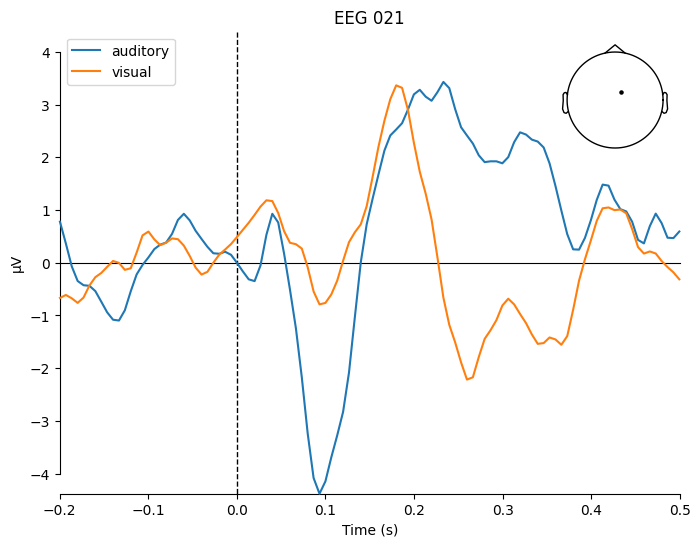

[<Figure size 800x600 with 2 Axes>]

In [19]:
mne.viz.plot_compare_evokeds(evokeds =  evoked_dict,
                             picks = ['EEG 021'],
                             legend = 'upper left', 
                             show_sensors = 'upper right')

We can also get a more detailed view of each Evoked object using other plotting methods such as plot_joint or plot_topomap. Here we’ll examine just the EEG channels, and see the classic auditory evoked N100-P200 pattern over dorso-frontal electrodes, then plot scalp topographies at some additional arbitrary times:



Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


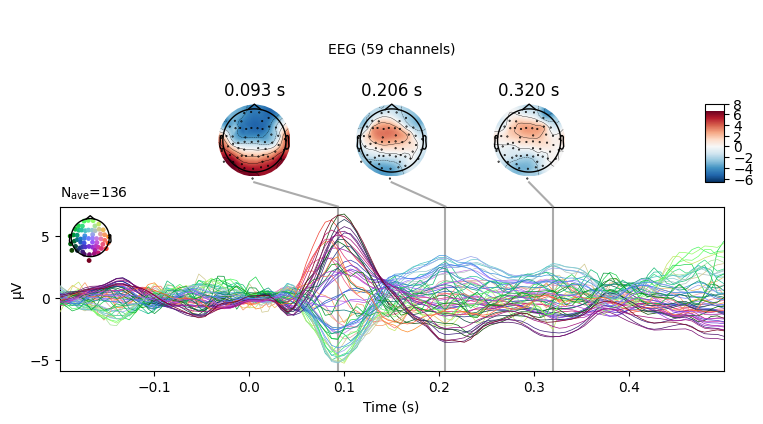

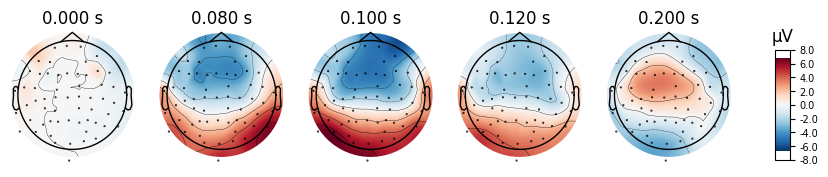

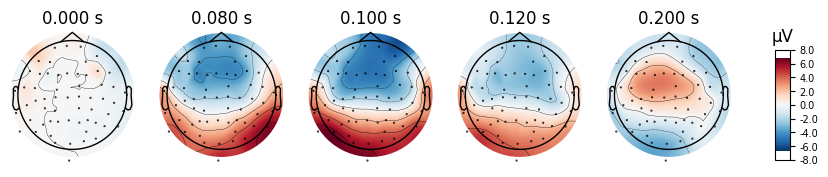

In [13]:
aud_evoked.plot_joint(picks='eeg')
aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

Evoked objects can also be combined to show contrasts between conditions, using the mne.combine_evoked function. A simple difference can be generated by passing weights=[1, -1]. We’ll then plot the difference wave at each sensor using plot_topo:

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


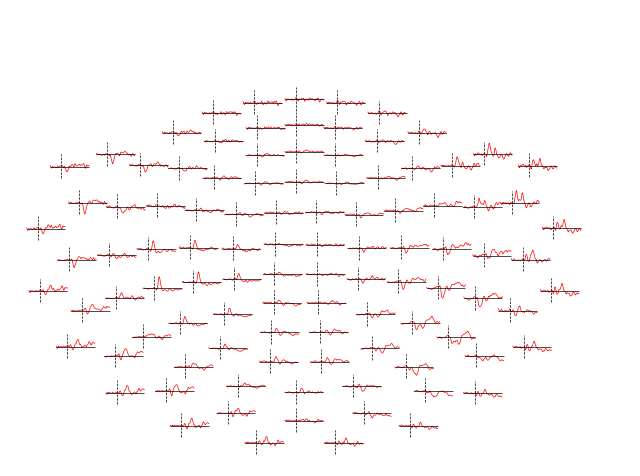

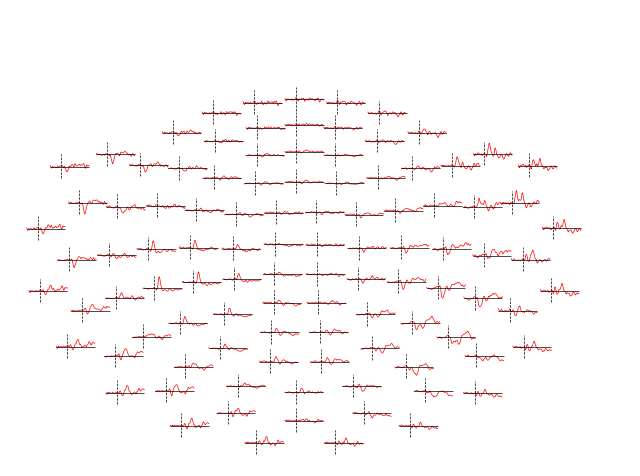

In [14]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick_types(meg='mag').plot_topo(color='r', legend=False)

# Inverse modeling

Finally, we can estimate the origins of the evoked activity by projecting the sensor data into this subject’s source space (a set of points either on the cortical surface or within the cortical volume of that subject, as estimated by structural MRI scans). MNE-Python supports lots of ways of doing this (dynamic statistical parametric mapping, dipole fitting, beamformers, etc.); here we’ll use minimum-norm estimation (MNE) to generate a continuous map of activation constrained to the cortical surface. MNE uses a linear inverse operator to project EEG+MEG sensor measurements into the source space. The inverse operator is computed from the forward solution for this subject and an estimate of the covariance of sensor measurements. For this tutorial we’ll skip those computational steps and load a pre-computed inverse operator from disk (it’s included with the sample data). Because this “inverse problem” is underdetermined (there is no unique solution), here we further constrain the solution by providing a regularization parameter specifying the relative smoothness of the current estimates in terms of a signal-to-noise ratio (where “noise” here is akin to baseline activity level across all of cortex).

In [15]:
# load inverse operator
inverse_operator_file = FIF_FILES[15]
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.
lambda2 = 1. / snr ** 2

Reading inverse operator decomposition from /Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing

## Generate the source time course (STC)

In [16]:
stc = mne.minimum_norm.apply_inverse(vis_evoked, inv_operator,
                                     lambda2=lambda2,
                                     method='MNE')

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 136
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
Applying inverse operator to "0.50 × visual/left + 0.50 × visual/right"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  71.0% variance
    Combining the current components...
[done]


In [17]:
SAMPLE_DATA_DIR = ph.cddir(ph.SAMPLE_DIR)
SAMPLE_SUBJECT_DIR = op.join(SAMPLE_DATA_DIR, "subjects")

# path to subjects' MRI files
# plot the STC
stc.plot(initial_time = 0.1, 
         hemi='split', 
         views=['lat', 'med'],
         subjects_dir = SAMPLE_SUBJECT_DIR)

Changed to:  /Users/jonghang/mne_data/MNE-sample-data
Using pyvistaqt 3d backend.

Using control points [9.00902715e-11 1.11056035e-10 4.50662663e-10]
